# Predicting Mahjong Discard Decisions with Machine Learning

This notebook builds a multiclass classifier that predicts which tile a player will discard next, using real Riichi Mahjong game states extracted from Tenhou logs.


In [1]:
import sqlite3
import gzip
import json

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (8, 4)

/Users/calvi/Documents/GitHub/ITCS-3156-Mahjong-Final-Project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading

We randomly sample discard states from the `Discard` table in the SQLite database. Each row holds a compressed JSON snapshot of the game state plus some metadata like `MaxDan` and `MinDan`.


In [2]:
db_path = "/Users/calvi/Downloads/datasets_positive.db"
TABLE = "Discard"
JSON_COL = "Data"

N_SAMPLES = 50000  

conn = sqlite3.connect(db_path)
cur = conn.cursor()

query = f"""
    SELECT {JSON_COL}, MaxDan, MinDan
    FROM {TABLE}
    ORDER BY RANDOM()
    LIMIT {N_SAMPLES};
"""

rows = cur.execute(query).fetchall()
conn.close()

len(rows)


50000

In [3]:
def parse_state_to_features_and_label(state: dict, max_dan: int, min_dan: int):
    """
    Converts a single Mahjong state into:
      - feature list
      - label = tile type (0-33) for the discarded tile

    Returns (features, label) or (None, None) if unusable.
    """
    feats = []

    # DB-level skill features
    feats.append(max_dan if max_dan is not None else 0)
    feats.append(min_dan if min_dan is not None else 0)

    # Round info
    feats.append(state.get("round_wind", 0))
    feats.append(state.get("num_honba", 0))
    feats.append(state.get("num_riichi", 0))
    feats.append(state.get("remain_tiles", 0))

    # Player identity
    player_wind = state.get("player_wind", 0)
    position = state.get("position", 0)
    feats.append(player_wind)
    feats.append(position)

    # Dora count
    dora_inds = state.get("dora_indicators", []) or []
    feats.append(len(dora_inds))

    # Hand tile counts (34 types)
    hand_counts = [0] * 34
    for tid in state.get("hand_tiles", []) or []:
        idx = tid // 4
        if 0 <= idx < 34:
            hand_counts[idx] += 1
    feats.extend(hand_counts)

    # Current player public info
    player_block = state.get(str(player_wind), {}) or {}
    curr_points = player_block.get("points", 0)
    feats.append(curr_points)

    curr_riichi_flag = 1 if player_block.get("riichi", False) else 0
    feats.append(curr_riichi_flag)

    # Opponent pressure
    opp_riichi = 0
    opp_melds = 0
    for pid in range(4):
        pdata = state.get(str(pid), {}) or {}
        if pid != player_wind and pdata.get("riichi", False):
            opp_riichi += 1
        opp_melds += len(pdata.get("melds", []) or [])
    feats.append(opp_riichi)
    feats.append(opp_melds)

    # Label: tile type from chosen discard action
    valid_actions = state.get("valid_actions", []) or []
    if not valid_actions:
        return None, None

    chosen_idx = state.get("real_action_idx", state.get("action_idx"))
    if (
        chosen_idx is None
        or chosen_idx < 0
        or chosen_idx >= len(valid_actions)
    ):
        return None, None

    chosen_action = valid_actions[chosen_idx]
    a_type = chosen_action.get("type")

    # 1 = discard, 7 = riichi (discard + riichi)
    if a_type not in (1, 7):
        return None, None

    tiles = chosen_action.get("tiles", [])
    if not tiles:
        return None, None

    tile_id = tiles[0]
    if tile_id is None or tile_id < 0:
        return None, None

    tile_type = tile_id // 4   

    return feats, tile_type


In [4]:
X_list = []
y_list = []

for blob, max_dan, min_dan in tqdm(rows, desc="Parsing states"):
    if blob is None:
        continue
    try:
        state = json.loads(gzip.decompress(blob))
    except Exception:
        continue

    feats, label = parse_state_to_features_and_label(state, max_dan, min_dan)
    if feats is None:
        continue

    X_list.append(feats)
    y_list.append(label)

len(X_list), len(y_list)


Parsing states: 100%|██████████| 50000/50000 [00:01<00:00, 47872.40it/s]


(50000, 50000)

## 3. Build Dataset

We convert the feature lists to a NumPy array and inspect the shape and label distribution.


In [5]:
X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.int64)

X.shape, y.shape


((50000, 47), (50000,))

0     1947
1     1358
2      978
3      880
4      821
5      871
6     1046
7     1356
8     1945
9     2018
10    1405
11    1009
12     876
13     785
14     876
15     976
16    1446
17    1976
18    2031
19    1392
20     977
21     879
22     802
23     900
24    1003
25    1395
26    2008
27    2232
28    2370
29    2390
30    2428
31    2205
32    2248
33    2171
dtype: int64

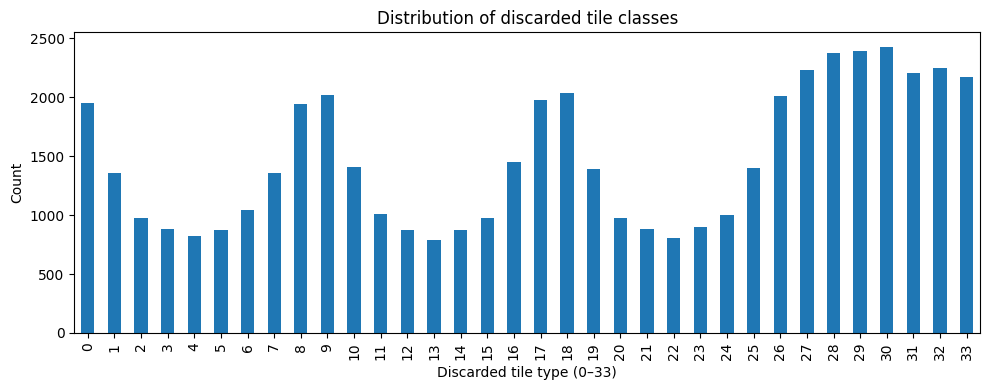

In [6]:
unique, counts = np.unique(y, return_counts=True)
label_counts = pd.Series(counts, index=unique).sort_index()

display(label_counts)

plt.figure(figsize=(10, 4))
label_counts.plot(kind="bar")
plt.xlabel("Discarded tile type (0–33)")
plt.ylabel("Count")
plt.title("Distribution of discarded tile classes")
plt.tight_layout()
plt.show()


## 4. Train/Test Split and Scaling

We use a 75/25 stratified split to preserve label proportions.  
Standardization is applied for Logistic Regression only.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

X_train.shape, X_test.shape


((37500, 47), (12500, 47))

## 5. Baseline Model

The baseline always predicts the most frequent discard tile in the training set.


In [ ]:
from sklearn.metrics import f1_score

most_common = pd.Series(y_train).value_counts().idxmax()

y_pred_base = np.full_like(y_test, fill_value=most_common)

base_acc = accuracy_score(y_test, y_pred_base)
base_f1_macro = f1_score(y_test, y_pred_base, average="macro")

print("Baseline most-frequent class:", most_common)
print("Baseline accuracy:", base_acc)
print("Baseline macro F1:", base_f1_macro)


Baseline most-frequent class: 30
Baseline accuracy: 0.04856
Baseline macro F1: 0.0027241842033219788


## 6. Multinomial Logistic Regression

We fit a multinomial Logistic Regression model as a linear baseline.


In [9]:
lr = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=300,
    n_jobs=1 
)

lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_f1_macro = f1_score(y_test, y_pred_lr, average="macro")

print("Logistic Regression Accuracy:", lr_acc)
print("Logistic Regression Macro F1:", lr_f1_macro)
print("\nClassification report (LogReg):")
print(classification_report(y_test, y_pred_lr, digits=3))


/Users/calvi/Documents/GitHub/ITCS-3156-Mahjong-Final-Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.1256
Logistic Regression Macro F1: 0.09374844116475392

Classification report (LogReg):
              precision    recall  f1-score   support

           0      0.147     0.158     0.152       487
           1      0.039     0.035     0.037       339
           2      0.033     0.024     0.028       245
           3      0.047     0.032     0.038       220
           4      0.015     0.010     0.012       205
           5      0.032     0.023     0.027       218
           6      0.054     0.042     0.047       262
           7      0.041     0.038     0.040       339
           8      0.127     0.150     0.138       486
           9      0.166     0.169     0.167       504
          10      0.064     0.060     0.062       351
          11      0.068     0.060     0.063       252
          12      0.062     0.046     0.052       219
          13      0.033     0.026     0.029       196
          14      0.040     0.032     0.036       219
          15   

## 7. Random Forest Classifier

We next fit a non-linear Random Forest classifier, which can capture interactions between tiles and context.


In [10]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=1,         
    random_state=RANDOM_STATE
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1_macro = f1_score(y_test, y_pred_rf, average="macro")

print("Random Forest Accuracy:", rf_acc)
print("Random Forest Macro F1:", rf_f1_macro)
print("\nClassification report (Random Forest):")
print(classification_report(y_test, y_pred_rf, digits=3))


Random Forest Accuracy: 0.41616
Random Forest Macro F1: 0.2681846378938944

Classification report (Random Forest):
              precision    recall  f1-score   support

           0      0.427     0.480     0.452       487
           1      0.377     0.153     0.218       339
           2      0.241     0.029     0.051       245
           3      0.125     0.009     0.017       220
           4      0.353     0.029     0.054       205
           5      0.208     0.023     0.041       218
           6      0.302     0.050     0.085       262
           7      0.327     0.209     0.255       339
           8      0.364     0.477     0.413       486
           9      0.433     0.488     0.459       504
          10      0.368     0.239     0.290       351
          11      0.244     0.087     0.129       252
          12      0.353     0.027     0.051       219
          13      0.100     0.005     0.010       196
          14      0.172     0.023     0.040       219
          15      0.

## 8. Model Comparison


In [12]:
results_df = pd.DataFrame({
    "Model": [
        "Baseline (most frequent)",
        "Logistic Regression",
        "Random Forest"
    ],
    "Accuracy": [
        base_acc,
        lr_acc,
        rf_acc
    ],
    "Macro F1": [
        base_f1_macro,
        lr_f1_macro,
        rf_f1_macro
    ]
})

results_df

,Model,Accuracy,Macro F1
0,Baseline (most frequent),0.04856,0.002724
1,Logistic Regression,0.12560,0.093748
2,Random Forest,0.41616,0.268185


## 8. Model Analysis


In [17]:
base_features = [
    "MaxDan", "MinDan",
    "round_wind", "num_honba", "num_riichi", "remain_tiles",
    "player_wind", "position",
    "num_dora",
]

hand_features = [f"hand_tile_{i}" for i in range(34)]

extra_features = [
    "curr_points",
    "curr_riichi_flag",
    "opp_riichi_count",
    "opp_meld_count",
]

feature_names = base_features + hand_features + extra_features

len(feature_names), X.shape[1]

(47, 47)

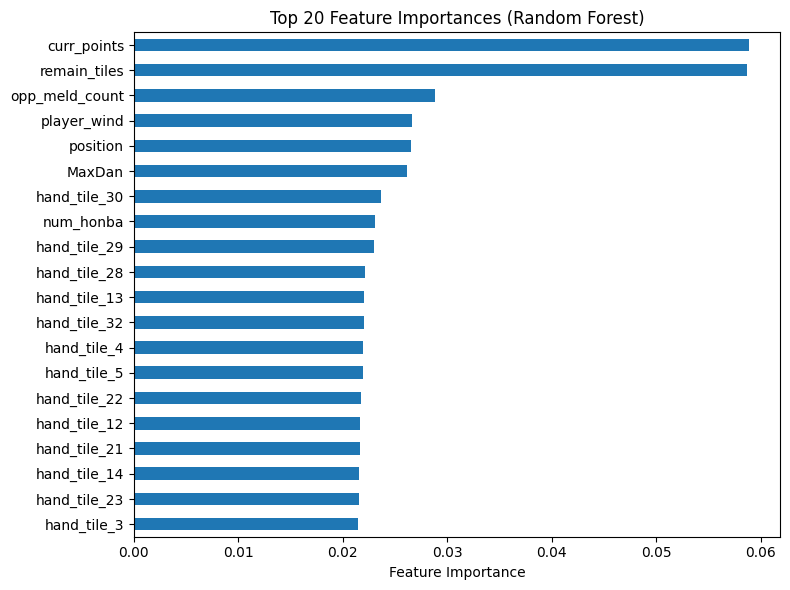

curr_points       0.058905
remain_tiles      0.058656
opp_meld_count    0.028793
player_wind       0.026634
position          0.026490
MaxDan            0.026132
hand_tile_30      0.023631
num_honba         0.023038
hand_tile_29      0.023029
hand_tile_28      0.022145
hand_tile_13      0.022037
hand_tile_32      0.022009
hand_tile_4       0.021978
hand_tile_5       0.021938
hand_tile_22      0.021783
hand_tile_12      0.021643
hand_tile_21      0.021625
hand_tile_14      0.021597
hand_tile_23      0.021571
hand_tile_3       0.021491
dtype: float64

In [ ]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

top_k = 20
top_imp = feat_imp.head(top_k)

plt.figure(figsize=(8, 6))
top_imp.sort_values().plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

top_imp


In [19]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, support = precision_recall_fscore_support(
    y_test, y_pred_rf, labels=np.arange(34), zero_division=0
)

f1_df = pd.DataFrame({
    "tile_type": np.arange(34),
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support,
})

f1_df.head()


,tile_type,precision,recall,f1,support
0,0,0.427007,0.480493,0.452174,487
1,1,0.376812,0.153392,0.218029,339
2,2,0.241379,0.028571,0.051095,245
3,3,0.125000,0.009091,0.016949,220
4,4,0.352941,0.029268,0.054054,205


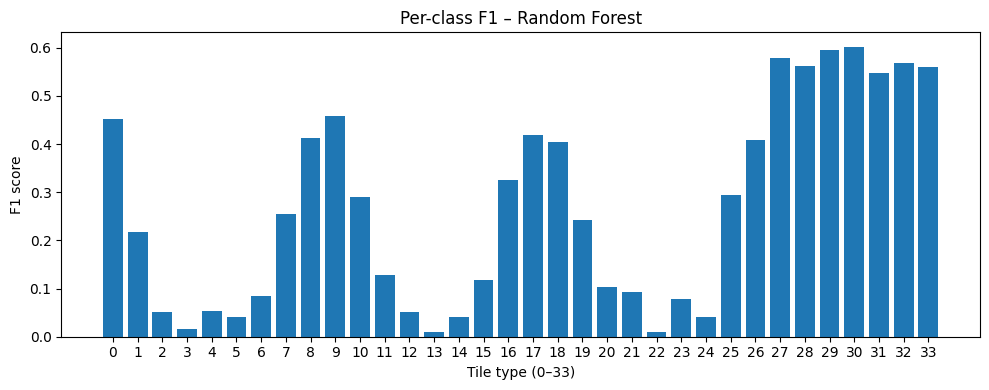

In [20]:
plt.figure(figsize=(10, 4))
plt.bar(f1_df["tile_type"], f1_df["f1"])
plt.xlabel("Tile type (0–33)")
plt.ylabel("F1 score")
plt.title("Per-class F1 – Random Forest")
plt.xticks(range(34))
plt.tight_layout()
plt.show()


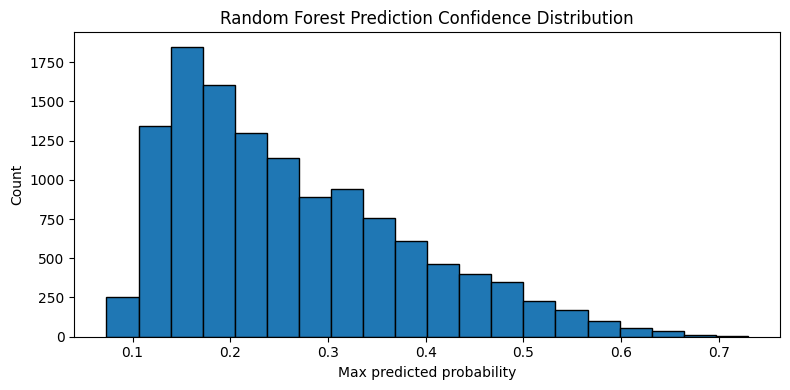

In [ ]:
probs = rf.predict_proba(X_test).max(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(probs, bins=20, edgecolor="black")
plt.xlabel("Max predicted probability")
plt.ylabel("Count")
plt.title("Random Forest Prediction Confidence Distribution")
plt.tight_layout()
plt.show()
